# Introduction

The goal of this project is to analize data from NFL teams spacificly looking at the offenseive and deffenseive score, rush yards, passing yards, and turn overs.

Questions: <br>
- Are there any patterns or trends in a teams preformace over the season? <br>
- Are there common factors that contribute to a teams success or failure?
- Does the teams record corolate with the offenseive yardage, deffenseive yardage, or turn overs?


### Collect & Clean Data

This data was collected From https://www.pro-football-reference.com website 

In [2]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:



# Defining a function to get a dictonary of all NFL teams.
class Nfl_stats:
    # Created an init method that sets a default dictonary that has its keays as nfl teams and values as the symbols to those teams
    
    def __init__(self):
        self.teams_symbols_dict = {}
        # setting url we want to get the data from using requests and beautifulsoup to find nfl teams 
        url = "https://www.pro-football-reference.com/teams/"
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html.parser')
        teams = soup.find("table", id="teams_active")

        # finding the team names in html
        all_team_names = teams.find_all("th", {"class":"left",'data-stat': 'team_name'})

        # team_names and urls for the teams
        team_names = []
        team_urls = []
        
        # parse throught data
        for i in all_team_names[1:]:
            team_links = i.find("a")
            team_names.append(team_links.text.lower())
            team_urls.append(team_links.get("href").split("/")[2])
            
        # updating teams_symbols_dict to show teams and symbols for those teams
        self.teams_symbols_dict.update(dict(zip(team_names, team_urls)))
        
            
        
    # Creating a dataframe that shows a team's stats for the season
    
    def team_stats(self, team, year):
        
        # using the teams and symbols dictonary to find the each teams data
        teams_dict = self.teams_symbols_dict
        url = "https://www.pro-football-reference.com/teams/"

        #making it easier to find the team's name in the teams_symbols_dict even if its uppercase or just the teams name not the city.
        full_team_name = ""
        for correct_team in teams_dict:
            if team in correct_team:
                full_team_name = correct_team
        
        # finding the team's stats 
        team_symbol = teams_dict[full_team_name.lower()]
        url = f"{url}{team_symbol}/{year}.htm"
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find("table", id="games")

        table_rows = table.find_all("tr")[2:]
        data = []
        for tr in table_rows:
            data.append([table_data.get_text(strip=True) for table_data in tr.find_all("td")])

        # creating a dataframe with the team's stats
        df = pd.DataFrame(data)
        
        # only getting the data from the columns that are relevent to the teams stats
        index = [0,1,4,6,8,9,10] + list(range(11,21))
        new_data = df.iloc[:,index].copy()

        # finding column names
        columns_html = table.find_all("th", {"scope":"col"})
        columns = []

        for col in columns_html[1:]:
            columns.append(col.text)
        # changing some column names and some that are duplicate so then we dont change both in dataframe later on
        columns[4] = "Result"
        columns[17] = "Toyd"
        columns[10] = "opp"
        columns[-4] = "Defense_TO"
        columns[-5] = "Defense_RushY"
        columns[-6] = "Defense_PassY"
        columns[-8] = "Defense_1stD"
        new_data.columns = [columns[num] for num in index]
        # renaming columns in our dataframe so the stats match up
        team_stats_df = new_data.rename({
            "Rec": "Record", 
            "Opp": "Opposing_team",
            "Tm":"Team_score",
            "TotYd": "Offense_TotYd",
            "Toyd": "Defense_TotYd",
            "opp": "Opp_score",
            "TO":"Offense_TO",
            "RushY": "Offense_RushY",
            "PassY": "Offense_PassY",
            "1stD": "Offense_1stD"


        }, axis="columns")

        # replacing some columns into numbers so then we can do better analysis
        result_encoder = {'Result': {'L': 0, 'T': 0,'W': 1,' ' : pd.NA}}
        team_stats_df.replace(result_encoder, inplace=True)
        
        # creating a week column so we know what week it is in the season
        week = list(range(1,len(team_stats_df) + 1))
        team_stats_df.insert(0, "Week", week)

        # creting a column for the team we wanted to see and making the first letter a capitol letter.
        team_name_col = pd.Series([f"{team.title()}"]).repeat(len(team_stats_df)).reset_index(drop=True)

        team_stats_df.insert(0,"Team_name", team_name_col)
        
        # making that need to be numbers into int's
        columns_int_list = ["Result","Team_score","Opp_score","Offense_1stD","Offense_TotYd","Offense_PassY","Offense_RushY","Offense_TO","Defense_1stD","Defense_TotYd","Defense_PassY","Defense_RushY","Defense_TO"]
        for column in columns_int_list:
            columns_list_na = team_stats_df[column].replace(["","bye"],0)
            team_stats_df[column]= columns_list_na.astype(int)
        
        return team_stats_df


### Explore Data

In [4]:
# calling the  
# to create an object we call Nfl_stats().team_stats("team name", Year)
panthers_data = Nfl_stats().team_stats("panthers", 2022)

panthers_data.head()

,Team_name,Week,Day,Date,Result,Record,Opposing_team,Team_score,Opp_score,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,Panthers,1,Sun,September 11,0,0-1,Cleveland Browns,24,26,15,261,207,54,1,23,355,138,217,0
1,Panthers,2,Sun,September 18,0,0-2,New York Giants,16,19,18,275,129,146,2,18,265,162,103,0
2,Panthers,3,Sun,September 25,1,1-2,New Orleans Saints,22,14,12,293,148,145,0,19,426,342,84,3
3,Panthers,4,Sun,October 2,0,1-3,Arizona Cardinals,16,26,11,220,180,40,3,20,338,206,132,1
4,Panthers,5,Sun,October 9,0,1-4,San Francisco 49ers,15,37,15,308,244,64,1,22,397,244,153,1


In [5]:
rows = panthers_data.shape[0]
columns = panthers_data.shape[1]
print(f"There are {rows} rows and {columns} coulumns within this dataset.")


There are 18 rows and 19 coulumns within this dataset.


In [6]:
num_teams_played = panthers_data[panthers_data["Opposing_team"] != "Bye Week"].groupby("Opposing_team").size().count()

print("Number of teams played against: " + str(num_teams_played))


teams_played = panthers_data.groupby("Opposing_team").size()
teams_played = teams_played[teams_played.index != "Bye Week"]
print("\n"
      "Breakdown of teams they played: \n",
      teams_played)

print("\nTeams played more than once: \n" +f"{str(teams_played[teams_played == 2])}")



Number of teams played against: 14

Breakdown of teams they played: 
 Opposing_team
Arizona Cardinals       1
Atlanta Falcons         2
Baltimore Ravens        1
Cincinnati Bengals      1
Cleveland Browns        1
Denver Broncos          1
Detroit Lions           1
Los Angeles Rams        1
New Orleans Saints      2
New York Giants         1
Pittsburgh Steelers     1
San Francisco 49ers     1
Seattle Seahawks        1
Tampa Bay Buccaneers    2
dtype: int64

Teams played more than once: 
Opposing_team
Atlanta Falcons         2
New Orleans Saints      2
Tampa Bay Buccaneers    2
dtype: int64


In [7]:
missing_values = panthers_data.isna().sum()

print("The amount of missing values for this dataset in each column: \n\n" + str(missing_values))

The amount of missing values for this dataset in each column: 

Team_name        0
Week             0
Day              0
Date             0
Result           0
Record           0
Opposing_team    0
Team_score       0
Opp_score        0
Offense_1stD     0
Offense_TotYd    0
Offense_PassY    0
Offense_RushY    0
Offense_TO       0
Defense_1stD     0
Defense_TotYd    0
Defense_PassY    0
Defense_RushY    0
Defense_TO       0
dtype: int64


In [8]:
unique_days = panthers_data.Day.unique()[panthers_data.Day.unique() != ""]
print(f"Unique days played: {unique_days}")

num_unique_days_played = panthers_data[panthers_data.Day != ""].groupby("Day")["Day"].count()

print(f"\nCount of days team played: \n{num_unique_days_played}")

panthers_result = panthers_data.Result
print(f"\nGames won: {str(panthers_result.sum())}")
print(f"Games lost: {str(panthers_result.count()-panthers_result.sum())}")


Unique days played: ['Sun' 'Thu' 'Sat']

Count of days team played: 
Day
Sat     1
Sun    15
Thu     1
Name: Day, dtype: int64

Games won: 7
Games lost: 11


In [9]:
won_against = panthers_data[panthers_data.Result == 1].Opposing_team
print(f"\nWon against: \n{won_against.to_string(index=False)}")

lost_against = panthers_data[panthers_data.Result == 0].Opposing_team
print(f"\nLost against: \n{lost_against.to_string(index=False)}")


Won against: 
  New Orleans Saints
Tampa Bay Buccaneers
     Atlanta Falcons
      Denver Broncos
    Seattle Seahawks
       Detroit Lions
  New Orleans Saints

Lost against: 
    Cleveland Browns
     New York Giants
   Arizona Cardinals
 San Francisco 49ers
    Los Angeles Rams
     Atlanta Falcons
  Cincinnati Bengals
    Baltimore Ravens
            Bye Week
 Pittsburgh Steelers
Tampa Bay Buccaneers


### Analyze Data

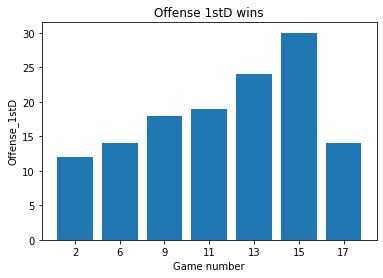

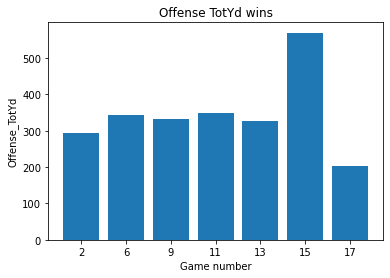

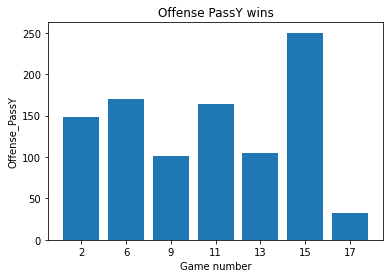

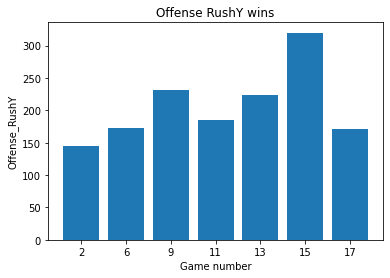

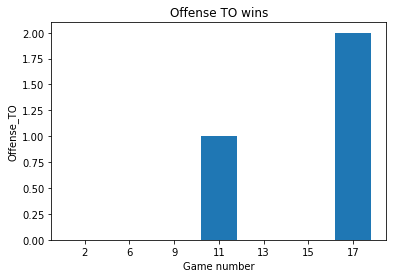

In [23]:
panthers_data = panthers_data[panthers_data["Opposing_team"] != "Bye Week"]

team_offense_stats = panthers_data[panthers_data["Result"] == 1].filter(regex="Offense")
for game in team_offense_stats:
    plt.bar(range(len(team_offense_stats)),team_offense_stats[game])
    title = game.split("_")
    plt.title(title[0] + " "+title[1] + " wins")
    plt.xticks(range(len(team_offense_stats)),team_offense_stats.index)
    plt.xlabel("Game number")
    plt.ylabel(f"{game}")
    plt.show()
    

### Interpret Results

### Conclusions